<a href="https://colab.research.google.com/github/NaamaSchweitzer/CV-waste-classification/blob/ModelProcessing/ModelProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O CV_Waste_Classification.ipynb \
  https://raw.githubusercontent.com/NaamaSchweitzer/CV-waste-classification/Preprocessing/CV_Waste_Classification.ipynb

%run CV_Waste_Classification.ipynb

--2025-11-29 12:45:05--  https://raw.githubusercontent.com/NaamaSchweitzer/CV-waste-classification/Preprocessing/CV_Waste_Classification.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116592 (114K) [text/plain]
Saving to: ‘CV_Waste_Classification.ipynb’

CV_Waste_Classifica 100%[===================>] 113.86K  --.-KB/s    in 0.01s   

2025-11-29 12:45:05 (10.9 MB/s) - ‘CV_Waste_Classification.ipynb’ saved [116592/116592]

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Kaggle authentication setup complete.
Dataset URL: https://www.kaggle.com/datasets/alyyan/trash-detection
License(s): MIT
100% 1.23G/1.23G [00:16<00:00, 79.1MB/s]
100% 1.23G/1.23G [00:16<00:00, 82.0MB/s]

## YOLOv8 (Ultralytics)


In [8]:
!pip install ultralytics
# ===== IMPORTANT: RUN THIS CELL FIRST =====
import os
from ultralytics import YOLO

# Set the CORRECT path to data.yaml
data_config_path = './trash-detection/Dataset/data.yaml'

# Verify it exists
if os.path.exists(data_config_path):
    print(f"✓ Data configuration found at {data_config_path}")
else:
    print(f"✗ Error: data.yaml not found at {data_config_path}")

# Set model name
model_name = 'yolov8n.pt'

# Helper function
def load_pretrained_model(name):
    return YOLO(name)

print(f"✓ Model name set to: {model_name}")
print(f"✓ data_config_path = {data_config_path}")

✓ Data configuration found at ./trash-detection/Dataset/data.yaml
✓ Model name set to: yolov8n.pt
✓ data_config_path = ./trash-detection/Dataset/data.yaml


Installation and Environment Setup
Before we begin, we need to install the ultralytics library. This library provides all the tools needed for training, evaluating, and using YOLOv8 models. The following cell installs the library, imports the required modules, and checks the environment (including GPU detection).

In [9]:
import ultralytics
from ultralytics import YOLO
import torch
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, Image

ultralytics.checks()

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Warning: GPU not detected. Training might be slow.")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.0/112.6 GB disk)

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


##Selecting a Base Model (Pretrained Backbone)
Model Selection and Transfer Learning
I chose the YOLOv8n (Nano version) model as our pretrained backbone. This is a lightweight and efficient model pre-trained on the large COCO dataset. Loading these weights gives us a strong foundation for Transfer Learning. We also verify that the path to the data.yaml file is correct.

In [10]:
import os
import yaml
import kagglehub
from ultralytics import YOLO

# Step 1: Download dataset
print("Downloading dataset...")
path = "./trash-detection"
dataset_root = f"{path}/Dataset"
print(f"Dataset root: {dataset_root}")

# Step 2: Read and fix data.yaml
original_yaml_path = f"{dataset_root}/data.yaml"
print(f"\nOriginal data.yaml contents:")
with open(original_yaml_path, 'r') as f:
    content = f.read()
    print(content)

# Step 4: Verify images exist
train_path = f"{dataset_root}/images/augmented_train"
val_path = f"{dataset_root}/images/new_val"
test_path = f"{dataset_root}/images/test"
print(f"\nVerifying paths:")
print(f"  Train images exist: {os.path.exists(train_path)} ({len(os.listdir(train_path)) if os.path.exists(train_path) else 0} files)")
print(f"  Val images exist: {os.path.exists(val_path)} ({len(os.listdir(val_path)) if os.path.exists(val_path) else 0} files)")
print(f"  Train images exist: {os.path.exists(test_path)} ({len(os.listdir(test_path)) if os.path.exists(test_path) else 0} files)")

Dataset root: ./trash-detection/Dataset

Original data.yaml contents:
names:
- dirt
- liquid
- marks
- trash
nc: 4
test: images/test
train: images/augmented_train
val: images/new_val


Verifying paths:
  Train images exist: True (2882 files)
  Val images exist: True (92 files)
  Train images exist: True (216 files)


## Model Training - First Run (Fine-Tuning Run 1)
Now we'll start the Fine-Tuning process. I decided to train for 30 epochs. In this run, we'll use the standard YOLOv8 parameters (including the default initial learning rate lr0 of 0.01). The results will be saved in a dedicated folder (YOLOv8n_Run1_DefaultLR) for comparison later. We use batch=-1 to allow the library to choose the optimal batch size for the available GPU memory

In [11]:
# Step 5: Train with corrected data.yaml
EPOCHS = 50
IMAGE_SIZE = 640
PROJECT_NAME = 'runs/detect'
RUN1_NAME = 'YOLOv8n_Run1_DefaultLR'

print(f"\nStarting Training Run 1 ({RUN1_NAME}) for {EPOCHS} epochs...")
print(f"Using data config: {original_yaml_path}")

yoloV8N = YOLO('yolov8n.pt')

results_run1 = yoloV8N.train(
    data=original_yaml_path,  # Use the corrected file
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    patience=10,
    batch=-1,
    project=PROJECT_NAME,
    name=RUN1_NAME
)
print("Training Run 1 finished successfully.")


Starting Training Run 1 (YOLOv8n_Run1_DefaultLR) for 50 epochs...
Using data config: ./trash-detection/Dataset/data.yaml
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./trash-detection/Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOv8n_R

## Step 5: Model Evaluation on Validation Set
Performance Evaluation and Training Run Comparison
After completing both runs, we evaluate the performance of the best model (best.pt) from each run on the validation set (the 30% we allocated earlier). The main metric we compare is mAP (Mean Average Precision). This step determines which learning rate was more effective and selects the winning model.

In [22]:
import os
from ultralytics import YOLO

# Path to the best trained model weights from Run 1.
# Note: The actual folder name includes '2' at the end as seen in the training output.
base_model_path = os.path.join(PROJECT_NAME,RUN1_NAME+'2')

model_path = os.path.join(base_model_path, 'weights', 'best.pt')

# Load the best model
print(f"Loading best model from: {model_path}")
loaded_model = YOLO(model_path)

# Evaluate the model on the test dataset using the data_config_path and specifying the 'test' split
print("\nEvaluating model on the test dataset...")
metrics_test = loaded_model.val(data=data_config_path, split='test')

print("\nEvaluation on test dataset completed.")

# Display key metrics from the test set evaluation
print("--- Test Set Metrics ---")
print(f"Overall mAP50: {metrics_test.results_dict['metrics/mAP50(B)']:.3f}")
print(f"Overall mAP50-95: {metrics_test.results_dict['metrics/mAP50-95(B)']:.3f}")

print(metrics_test.box.maps)



Loading best model from: runs/detect/YOLOv8n_Run1_DefaultLR2/weights/best.pt

Evaluating model on the test dataset...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 362.2±413.0 MB/s, size: 1006.5 KB)
val: Scanning /content/trash-detection/Dataset/labels/test.cache... 216 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 216/216 395.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 1.5it/s 9.2s
                   all        216       1427      0.757      0.754      0.788       0.52
                  dirt         74        268      0.961      0.996      0.995      0.737
                liquid         29         98      0.788       0.98      0.979      0.714
                 marks         88        583        0.9      0.652      0.835      0.397
   


Training and Validation Learning Curves:


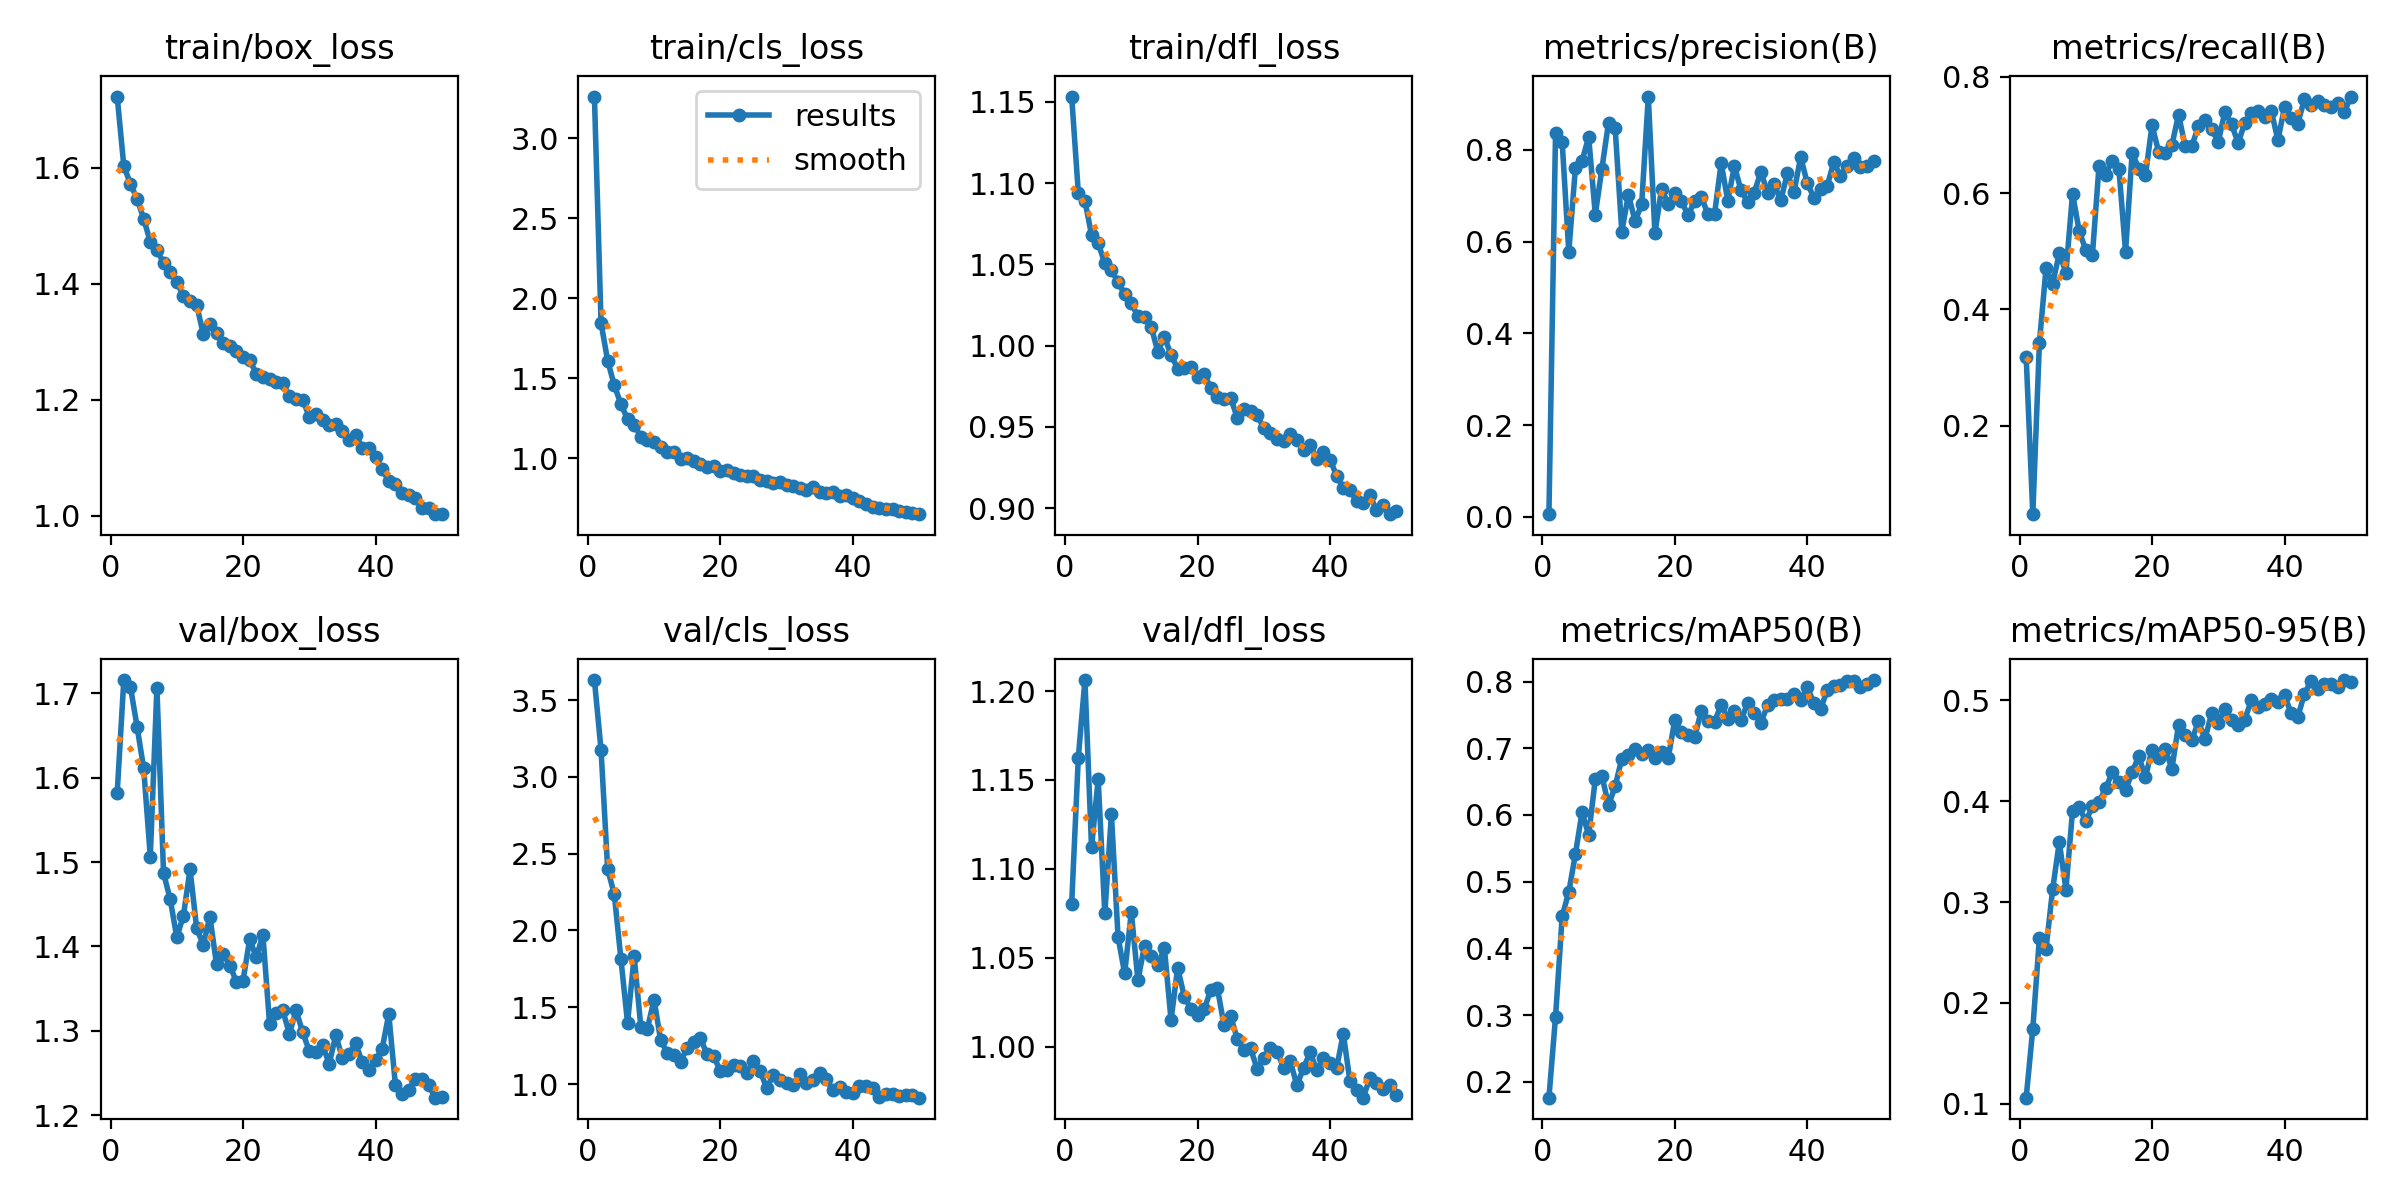


Confusion Matrix:


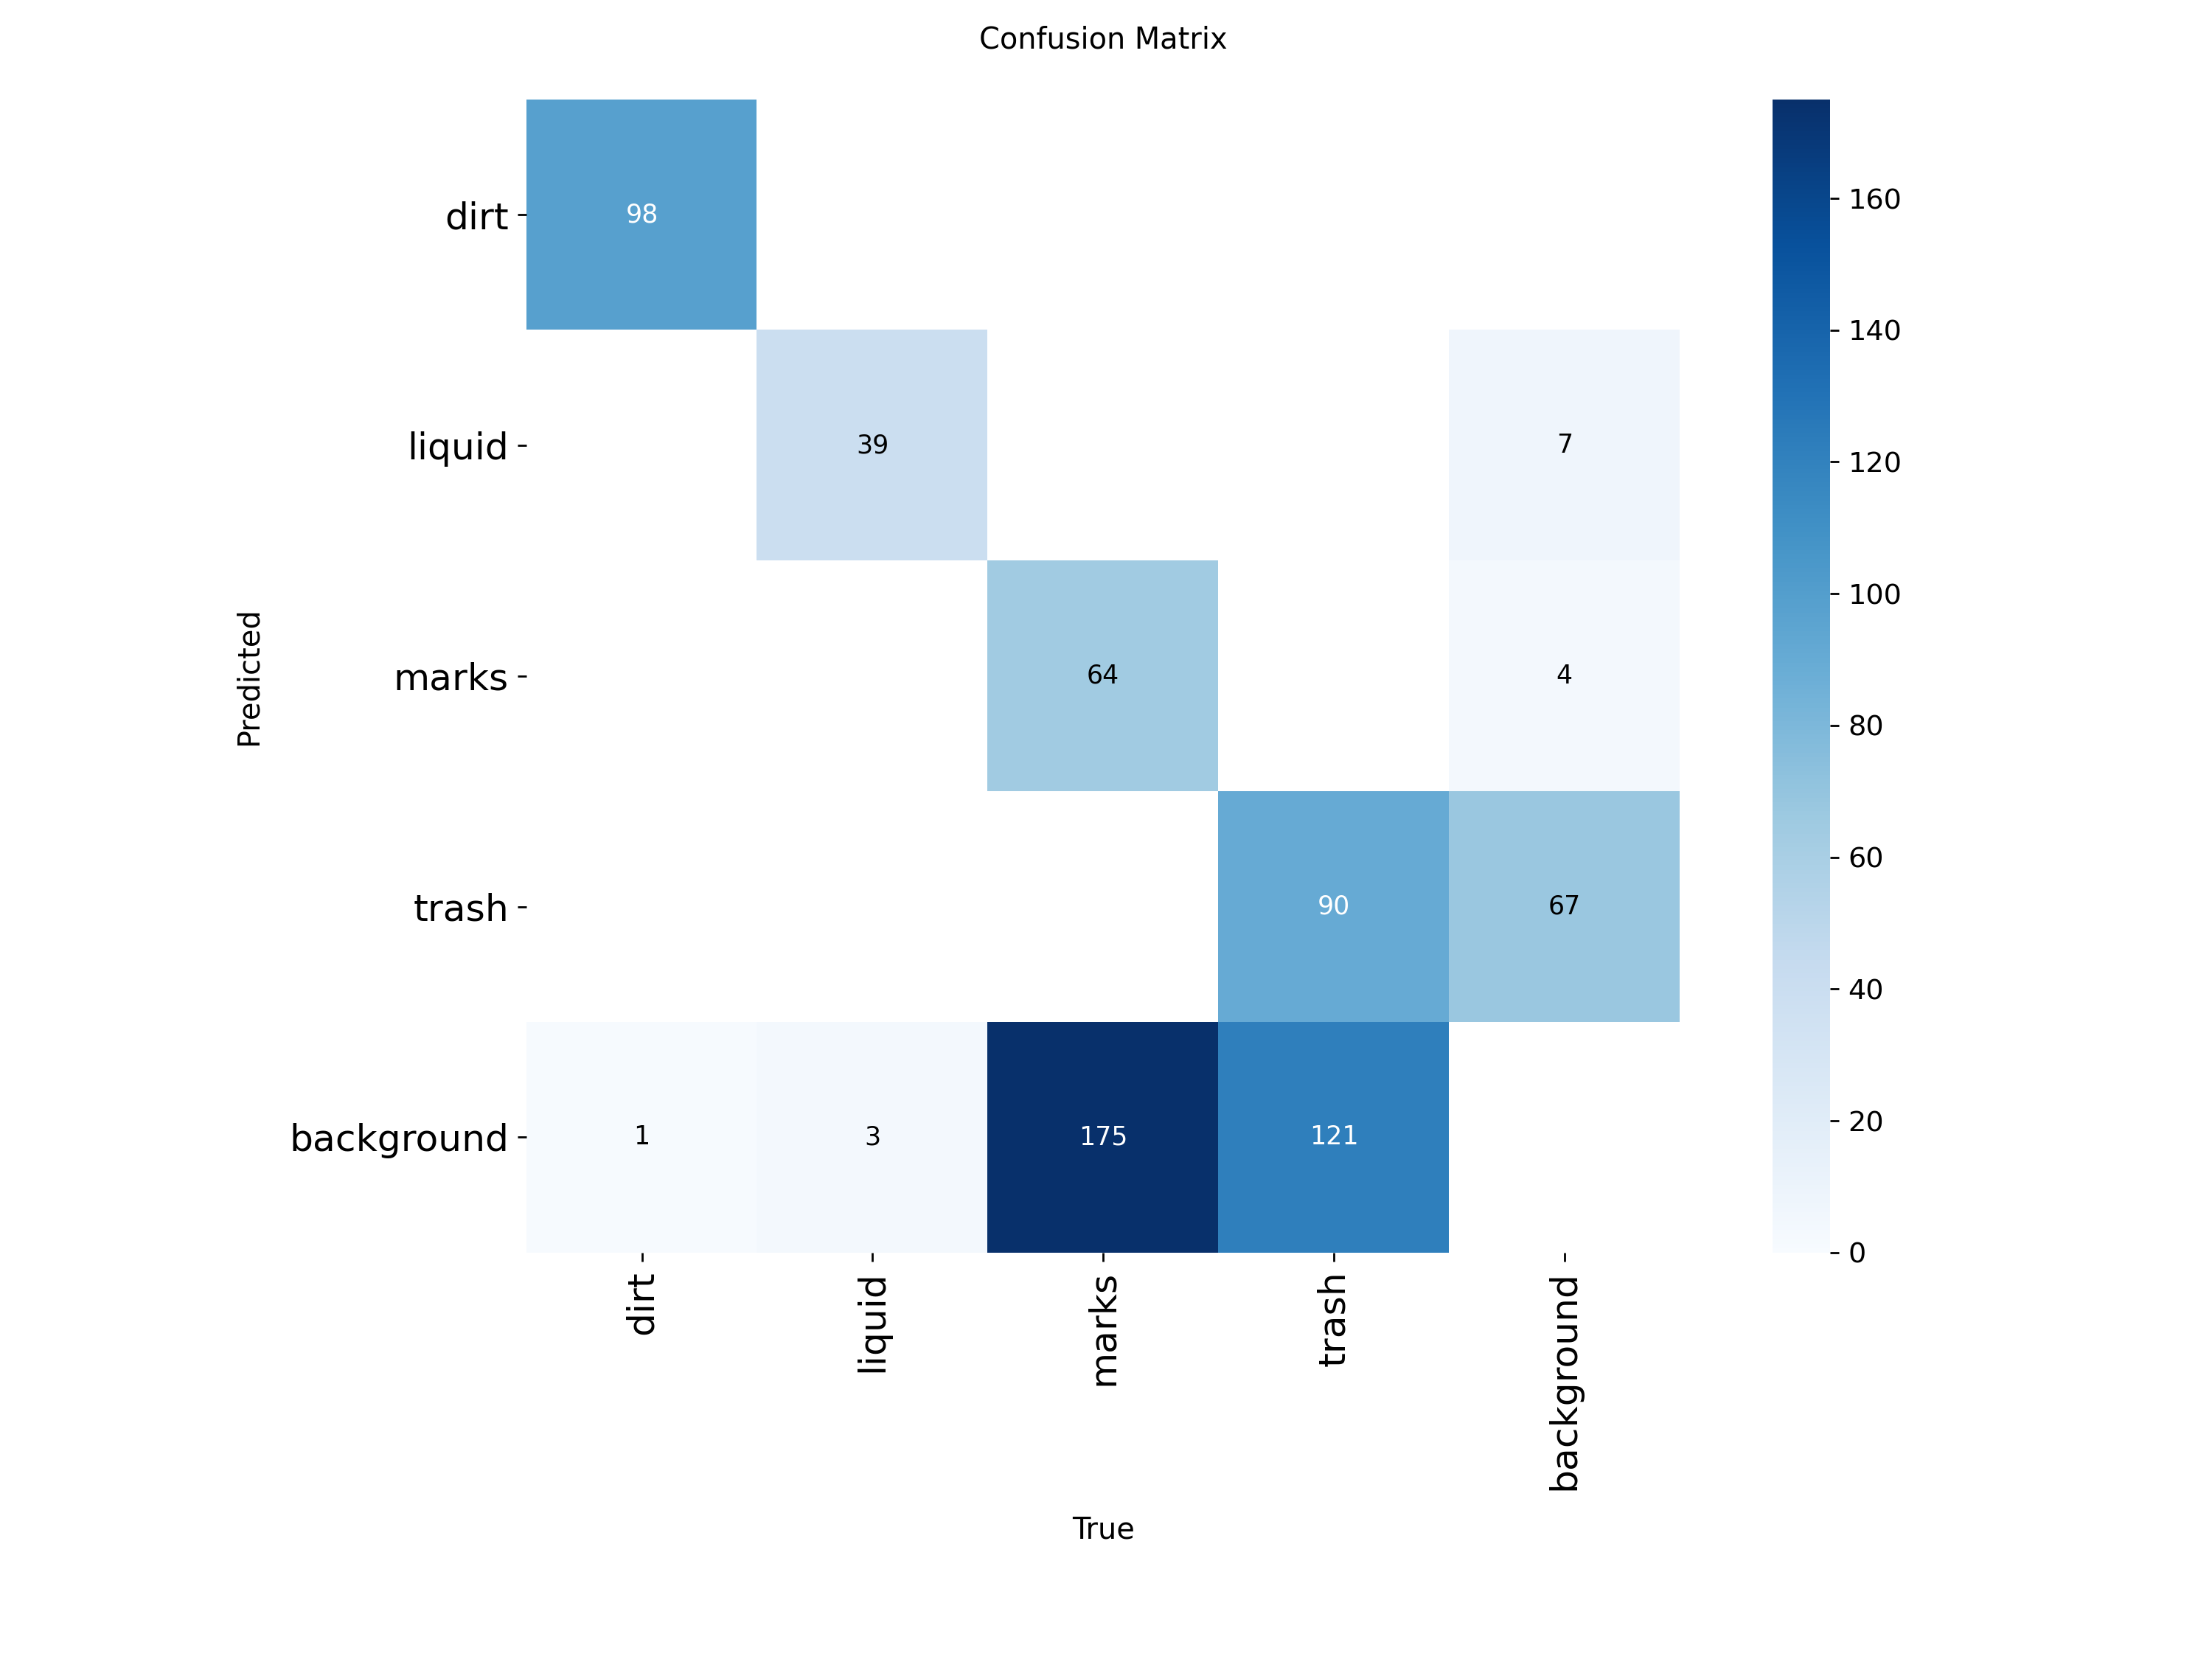

In [23]:
if os.path.exists(base_model_path):
    # 1. Display learning curves (results.png)
    results_path = os.path.join(base_model_path, 'results.png')
    if os.path.exists(results_path):
        print("\nTraining and Validation Learning Curves:")
        # Use IPython.display for clean display in notebook
        display(Image(filename=results_path, width=1000))
    else:
        print("Could not find results.png")

    # 2. Display Confusion Matrix
    confusion_matrix_path = os.path.join(base_model_path, 'confusion_matrix.png')
    if os.path.exists(confusion_matrix_path):
        print("\nConfusion Matrix:")
        display(Image(filename=confusion_matrix_path, width=800))
    else:
        print("Could not find confusion_matrix.png")
else:
    print(f"Error: Winning run directory not found: {base_model_path}")

## Results

On the test set I have got:

Overall: mAP50 = 0.788, mAP50–95 = 0.520

dirt: mAP50 = 0.995

liquid: mAP50 = 0.979

marks: mAP50 = 0.835

trash: mAP50 = 0.343 ⟵ the main weakness

So the model is pretty strong already, with “trash” clearly being the hard class.

## Model Training (Run 2 - Lower Learning Rate)
To experiment with hyperparameters, I performed a second training for the barebones models with a few adjustments on the hyper parameter. First of all i want to adjust the Learning rate to 0.001. Second , I had a look at the trash images and most of the times it's really small and cluttered , so i decided i will convert the images to higher pixel dimension , so more pixels will help to identify the trash .

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # or your current best.pt to fine-tune

model.train(
    data="./trash-detection/Dataset/data.yaml",
    epochs=50,          # a bit longer
    imgsz=800,          # more detail than 640
    lr0=0.001,          # slightly lower LR for stability
    lrf=0.01,           # keep same final LR factor
    cos_lr=True,        # smoother LR decay
    patience=20,
    project="runs/detect",
    name="YOLOv8n_Run3_highres",
)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=./trash-detection/Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOv8n_Run3_highres2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0